In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt

In [29]:
clients = 15  # the total number of clients
communicationRounds = 15  # the number of communications between the edges and the global model
numOfEdges = 3 # the number of edge-aggregators
edgeEpochs = 2 # the number of communications between an edge and its clients
numEpochs = 5  # the number of local epochs on clients
lr = 0.1  # training rate
localBatchSize = 10  # batch size

In [30]:
# download the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainData = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testData = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testLoader = torch.utils.data.DataLoader(testData, batch_size=10, shuffle=False)
# Shuffle the data
indices = list(range(len(trainData)))
dataShuffled = [trainData[i] for i in indices]
# create equal-sized subsets for each client in an iid manner
clientData = []
# each client will get a sample of size 500
sampleSize = 500
for label in range(clients):
    if label == 1:
        labelData = dataShuffled
    elif label > 9:
        labelData = dataShuffled
    else:
        labelData = [data for data in dataShuffled if data[1] == label]
    subsetSize = min(len(labelData), sampleSize)
    dataClient = labelData[:subsetSize]
    clientData.append(dataClient)

In [31]:
globalModel = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 12 * 12, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [32]:
edgeModels = []
for _ in range(numOfEdges):
    edgeModel = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(64 * 12 * 12, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    edgeModels.append(edgeModel)

Cloud Communication Round: 1
Edge Communication Round: 1 on edge 1
Client 1 belonging to edge 1, finished training for: 5 epoch(s)
Client 2 belonging to edge 1, finished training for: 5 epoch(s)
Client 3 belonging to edge 1, finished training for: 5 epoch(s)
Client 4 belonging to edge 1, finished training for: 5 epoch(s)
Client 5 belonging to edge 1, finished training for: 5 epoch(s)
Client 6 belonging to edge 1, finished training for: 5 epoch(s)
Client 7 belonging to edge 1, finished training for: 5 epoch(s)
Edge Communication Round: 2 on edge 1
Client 1 belonging to edge 1, finished training for: 5 epoch(s)
Client 2 belonging to edge 1, finished training for: 5 epoch(s)
Client 3 belonging to edge 1, finished training for: 5 epoch(s)
Client 4 belonging to edge 1, finished training for: 5 epoch(s)
Client 5 belonging to edge 1, finished training for: 5 epoch(s)
Client 6 belonging to edge 1, finished training for: 5 epoch(s)
Client 7 belonging to edge 1, finished training for: 5 epoch(s)

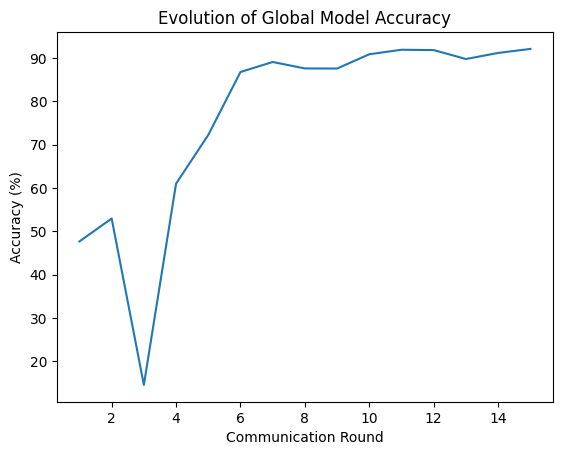

In [33]:
accuracies = []
# iterate over all rounds
for rnd in range(communicationRounds):
    # print round number
    print(f"Cloud Communication Round: {rnd + 1}")
    # to save edges parameters
    params = []
    # iterate over all edge models
    for i, edgeModel in enumerate(edgeModels):
        # calculate the start and end indices of the clients on the current edge
        startClient = (i * (clients // numOfEdges))
        endClient = ((i + 1) * (clients // numOfEdges))
        # select clients for the current edge
        selectedClients = []
        if i == 0:
            selectedClients = list(range(7))  # number of clients on edge 1
        elif i == 1:
            selectedClients = list(range(7, 11))  # number of clients on edge 2
        elif i == 2:
            selectedClients = list(range(11, 15))  # number of clients on edge 3
        # save local clients models parameters within the current edge
        edgeParams = []
        clientLosses = []
        # iterate over selected clients on the current edge
        for edgeRound in range(edgeEpochs):
            print(f"Edge Communication Round: {edgeRound + 1} on edge {i + 1}")
            for client in selectedClients:
                # local model
                clientModel = nn.Sequential(*edgeModel)
                # load the data to the model
                trainLoader = data.DataLoader(clientData[client], batch_size=localBatchSize, shuffle=False)
                # client optimizer and loss function
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.SGD(clientModel.parameters(), lr=lr)
                # train model on client k for the defined local epochs
                for epoch in range(numEpochs):
                    # perform forward pass and backpropagation, updating the local model
                    for inputs, labels in trainLoader:
                        optimizer.zero_grad()
                        outputs = clientModel(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        clientLosses.append(loss.item())  # Store the loss
                # print client's k training progress
                print(f"Client {client + 1} belonging to edge {i + 1}, finished training for: {numEpochs} epoch(s)")
                # aggregate local models parameters of the clients of the current edge
                local_params = [param.data for param in clientModel.parameters()]
                edgeParams.append(local_params)
        # select the 3 clients with the smallest losses
        selectedClients = sorted(selectedClients, key=lambda x: clientLosses[x])[:2]
        # average the parameters from the selected local models within the current edge
        selectedParams = [params for i, params in enumerate(edgeParams) if i in selectedClients]
        averagedParameters = [
            torch.mean(torch.stack(params), dim=0) for params in zip(*selectedParams)
        ]
        # update the model on the current edge
        for edgeParam, avgParam in zip(edgeModel.parameters(), averagedParameters):
            edgeParam.data = avgParam
    # aggregate all edge models
    averagedParameters = [
        torch.mean(torch.stack(params), dim=0) for params in zip(*(edgeModel.parameters() for edgeModel in edgeModels))
    ]
    # update the global model parameters
    for globalParam, avgParam in zip(globalModel.parameters(), averagedParameters):
        globalParam.data = avgParam
    # send the global model parameters back to the edges for the next communication round
    for edgeModel in edgeModels:
        edgeModel.load_state_dict(globalModel.state_dict())
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testLoader:
            outputs = globalModel(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
print(f"Training is finished after {communicationRounds} communication rounds on a total of {clients} clients clustered across {numOfEdges} edges!")

# Plot the evolution of global model accuracy
plt.plot(range(1, communicationRounds + 1), accuracies)
plt.xlabel("Communication Round")
plt.ylabel("Accuracy (%)")
plt.title("Evolution of Global Model Accuracy")
plt.show()

In [34]:
device = torch.device("cpu")
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testLoader:
        images, labels = images.to(device), labels.to(device)
        outputs = globalModel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 92.13%
